# Initialization

To run this notebook:
- place .env file with your `OPEN_AI_KEY` and `VOYAGE_AI_KEY` in the root of the project
- create virtual environment and install requirements.txt

In [2]:
!pip3 install -r requirements.txt -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 108.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [3]:
import os
from dotenv import load_dotenv

import numpy as np

import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

import tiktoken
from openai import OpenAI
import voyageai

In [8]:
load_dotenv()

OPEN_AI_KEY = os.getenv('OPEN_AI_KEY')
VOYAGE_AI_KEY = os.getenv('VOYAGE_AI_KEY')

In [5]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Voyage
https://blog.voyageai.com/2024/05/05/voyage-large-2-instruct-instruction-tuned-and-rank-1-on-mteb/

https://docs.voyageai.com/docs/embeddings

In [9]:
vo = voyageai.Client(api_key=VOYAGE_AI_KEY)
tokenizer_voyage = AutoTokenizer.from_pretrained("voyageai/voyage-large-2", legacy=False)

def get_voyageai(texts):
    embeddings = vo.embed(texts, model="voyage-large-2", input_type="document").embeddings
    return embeddings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

## Alibaba

https://huggingface.co/Alibaba-NLP/gte-large-en-v1.5

In [10]:
tokenizer_alibaba = AutoTokenizer.from_pretrained('Alibaba-NLP/gte-large-en-v1.5')
model_alibaba = AutoModel.from_pretrained('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True).to(device)

def get_alibaba(texts):
    batch_dict_alibaba = tokenizer_alibaba(texts, max_length=512, padding=True, truncation=True, return_tensors='pt').to(device)
    outputs_alibaba = model_alibaba(**batch_dict_alibaba)
    embeddings_alibaba = F.normalize(outputs_alibaba.last_hidden_state[:, 0], p=2, dim=1).tolist()
    return embeddings_alibaba

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/59.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/new-impl:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

## Jina

https://huggingface.co/jinaai/jina-embeddings-v3

In [11]:
tokenizer_jina = AutoTokenizer.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True)
model_jina = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True, revision="main").to(device)


def get_jina(texts, task="text-matching", max_length=512, truncate_dim=None):
    encoded_input = tokenizer_jina(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)
    with torch.inference_mode():
        embeddings = model_jina.encode(texts, task=task, max_length=max_length, truncate_dim=truncate_dim)
    return F.normalize(torch.tensor(embeddings), p=2, dim=1).numpy()

tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/51.1k [00:00<?, ?B/s]

embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- mlp.py
- stochastic_depth.py
- mha.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- embedding.py
- block.py
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/flash_attn/ops/t

model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

## OpenAI

https://platform.openai.com/docs/guides/embeddings#embedding-models

In [12]:
client = OpenAI(api_key=OPEN_AI_KEY)
tokenizer_openai = tiktoken.encoding_for_model("text-embedding-3-large")

def get_openai(texts):
    response = client.embeddings.create(input=texts, model="text-embedding-3-large")
    return [item.embedding for item in response.data]

## BioBert

https://huggingface.co/pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb

In [13]:
tokenizer_biobert = AutoTokenizer.from_pretrained('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb')
model_biobert = AutoModel.from_pretrained('pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb').to(device)

def get_biobert(texts):
    encoded_input_biobert = tokenizer_biobert(texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output_biobert = model_biobert(**encoded_input_biobert)
    embeddings_biobert = mean_pooling(model_output_biobert, encoded_input_biobert['attention_mask'])
    embeddings_biobert = F.normalize(embeddings_biobert, p=2, dim=1).tolist()
    return embeddings_biobert

tokenizer_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

## MedEmbed

https://huggingface.co/abhinand/MedEmbed-small-v0.1

In [14]:
tokenizer_medembed = AutoTokenizer.from_pretrained('abhinand/MedEmbed-small-v0.1')
model_medembed = AutoModel.from_pretrained('abhinand/MedEmbed-small-v0.1').to(device)


def get_medembed(texts):
    encoded_input_medembed = tokenizer_medembed(texts, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output_medembed = model_medembed(**encoded_input_medembed)
    embeddings_medembed = mean_pooling(model_output_medembed, encoded_input_medembed['attention_mask'])
    embeddings_medembed = F.normalize(embeddings_medembed, p=2, dim=1).tolist()
    return embeddings_medembed

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

## ModernBERT

https://huggingface.co/blog/modernbert

In [15]:
tokenizer_modernbert = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
model_modernbert = AutoModel.from_pretrained("answerdotai/ModernBERT-base", torch_dtype=torch.float16).to(device)

def get_modernbert(texts):
    encoded_input_modernbert = tokenizer_modernbert(texts, padding=True, truncation=True, return_tensors="pt", max_length=512).to(device)
    with torch.no_grad():
        model_output_modernbert = model_modernbert(**encoded_input_modernbert)
    embeddings_modernbert = mean_pooling(model_output_modernbert, encoded_input_modernbert['attention_mask'])
    embeddings_modernbert = F.normalize(embeddings_modernbert, p=2, dim=1).tolist()
    return embeddings_modernbert

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [16]:
tokenizer_modernbert_gte = AutoTokenizer.from_pretrained("Alibaba-NLP/gte-modernbert-base")
model_modernbert_gte = AutoModel.from_pretrained("Alibaba-NLP/gte-modernbert-base", torch_dtype=torch.float16).to(device)

def get_modernbert_gte(texts):
    encoded_input_modernbert = tokenizer_modernbert_gte(texts, max_length=8192, padding=True, truncation=True, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output_modernbert = model_modernbert_gte(**encoded_input_modernbert)
    embeddings_modernbert = model_output_modernbert.last_hidden_state[:, 0]
    embeddings_modernbert = F.normalize(embeddings_modernbert, p=2, dim=1).tolist()
    return embeddings_modernbert

tokenizer_config.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

In [17]:
models = [
    ("openai", get_openai, tokenizer_openai, 1000),
    ("voyage", get_voyageai, tokenizer_voyage, 128),
    ("alibaba", get_alibaba, tokenizer_alibaba, 8),
    ("jina", get_jina, tokenizer_jina, 8),
    ("biobert", get_biobert, tokenizer_biobert, 8),
    ("medembed", get_medembed, tokenizer_medembed, 8),
    ("modernbert_gte", get_modernbert_gte, tokenizer_modernbert_gte, 8),
    ("modernbert", get_modernbert, tokenizer_modernbert, 8),
]

In [18]:
def get_embeddings(texts, model, method, batch_size=8):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Processing {model}"):
        batch_texts = texts[i:i + batch_size]
        batch_embeddings = method(batch_texts)
        embeddings.extend(batch_embeddings)
    return embeddings

# Queries embeddings

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

In [28]:
queries_pairs = [
    ("What are the major predispositions for renal failure?", "Which factors contribute to the development of CKD?"),
    ("Deposition of copper in the Descemet's membrane as a symptom of Wilson disease", "Development of Kayser–Fleischer rings in course of hereditary hypercupremia"),
    ("Difference between STEMI and NSTEMI", "ST-segment elevation vs. non-ST elevation myocardial infarction"),
    ("NAFLD and its relation to insulin resistant diabetes", "How is non-alcoholic fatty liver disease linked to metabolic syndrome?"),
    ("Role of M1dG in oxidative DNA damage", "Impact of malondialdehyde-deoxyguanine adducts on genomic stability"),
    ("FLICE involvement in immune response", "How caspase 8 inhibitory protein affects cytokine production"),
    ("Earwax removal is sometimes necessary when natural cleaning mechanisms fail.", "When cerumen does not clear on its own, medical intervention may be required."),
    ("What are the symptoms of Ribose-5-Phosphate Isomerase deficiency?", "What clinical signs indicate an enzymatic disorder which may be related ribose conversion?"),
    ("Risk factors for MRSA infections", "Prevalence of methicillin-resistant Staphylococcus aureus"),
    ("Have you been experiencing cardialgia?", "Do you feel discomfort or pain near the heart area?"),
]

In [29]:
queries_df = pd.DataFrame(queries_pairs, columns=["question 1", "question 2"])
queries_df.head()

,question 1,question 2
0,What are the major predispositions for renal f...,Which factors contribute to the development of...
1,Deposition of copper in the Descemet's membran...,Development of Kayser–Fleischer rings in cours...
2,Difference between STEMI and NSTEMI,ST-segment elevation vs. non-ST elevation myoc...
3,NAFLD and its relation to insulin resistant di...,How is non-alcoholic fatty liver disease linke...
4,Role of M1dG in oxidative DNA damage,Impact of malondialdehyde-deoxyguanine adducts...


Processing openai:   0%|          | 0/2 [00:00<?, ?it/s]

Processing openai:   0%|          | 0/2 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/2 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/2 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/2 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/2 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/2 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/2 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/2 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/2 [00:00<?, ?it/s]

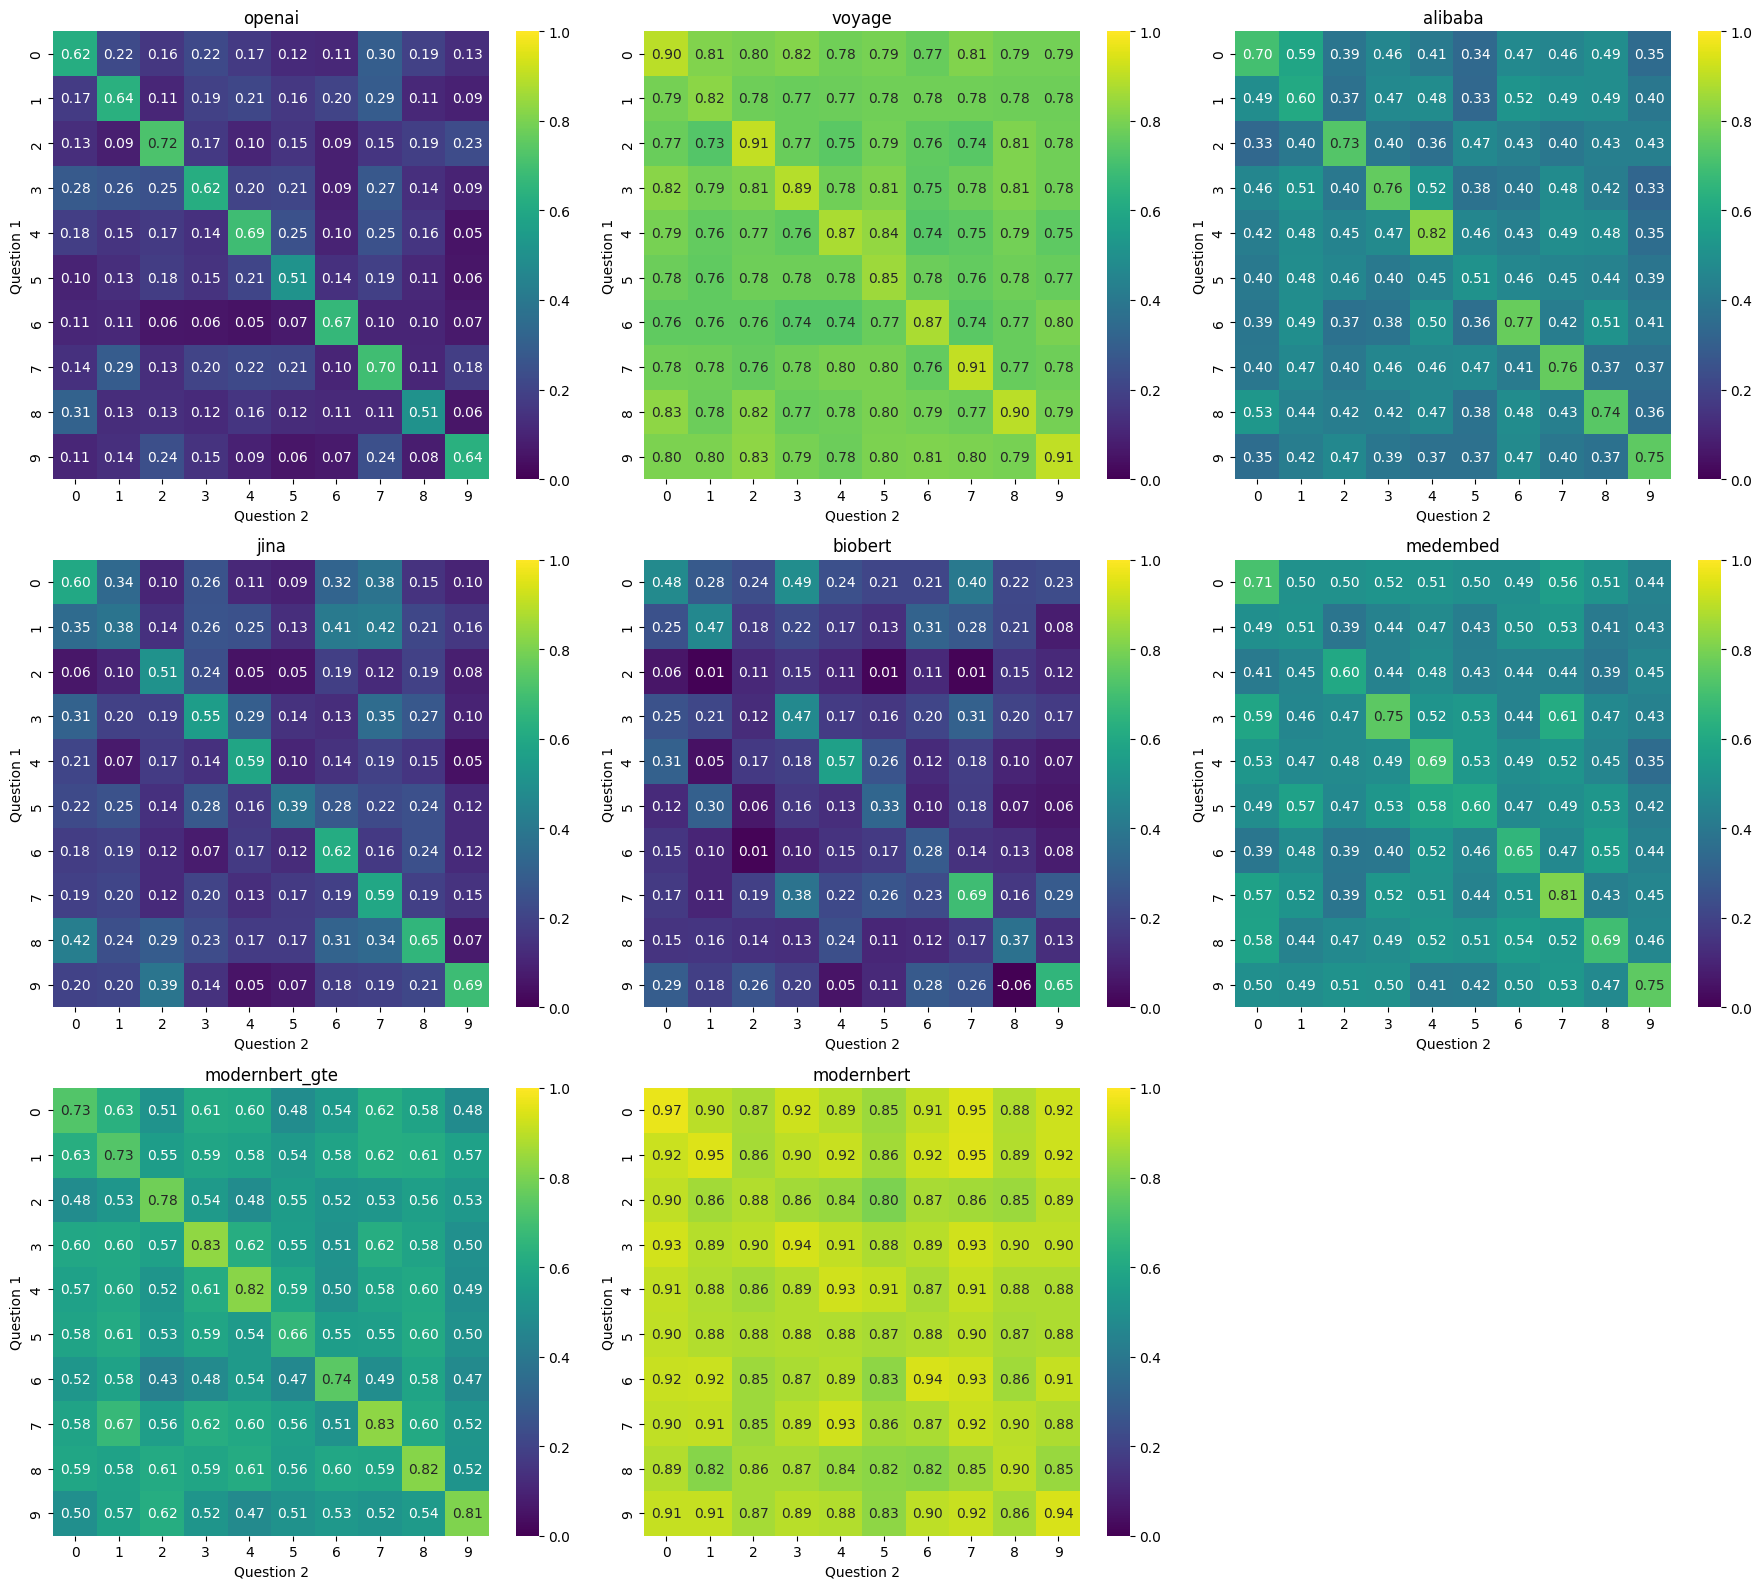

In [30]:
plt.figure(figsize=(18, 16))

for i, (model, method, *_) in enumerate(models, start=1):
    embeddings_q1 = get_embeddings(queries_df["question 1"].tolist(), model, method)
    embeddings_q2 = get_embeddings(queries_df["question 2"].tolist(), model, method)

    similarity_matrix = cosine_similarity(embeddings_q1, embeddings_q2)

    plt.subplot(3, 3, i)  # lines, columns, i
    sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True, vmin=0, vmax=1)
    plt.title(model)

    plt.xlabel('Question 2')
    plt.ylabel('Question 1')

plt.tight_layout()
plt.show()

#  How documents and queries work together

For the demo we've downloaded from [PubMed](https://pubmed.ncbi.nlm.nih.gov/) all papers for these [MeSH terms](https://meshb.nlm.nih.gov/treeView) for last 5 years:

- Diabetes, Gestational [C19.246.200] (6366 abstracts).

In [27]:
gestational_df = pd.read_csv('data/gestational.csv')

In [ ]:
for model, method, _, batch_size in models:
    gestational_df[model] = get_embeddings(gestational_df['text'].tolist(), model, method, batch_size)

In [ ]:
def plot_violin(df, category_descriptions):
    n_cols, n_rows = 4, (len(models) + 3) // 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
    global_ylim = (0, 1)

    for i, (model, method, *_) in enumerate(models):
        similarities, categories = [], []
        for category_description in category_descriptions:
            sims = cosine_similarity(df[model].tolist(), get_embeddings([category_description], model, method)).flatten()
            similarities.extend(sims)
            categories.extend([category_description] * len(sims))
        ax = axes[i // n_cols, i % n_cols]

        titles = ["LADA" if desc == "Latent autoimmune diabetes in adults" else desc for desc in categories]
        sns.violinplot(
            x=titles,
            y=similarities, ax=ax
        )
        ax.set_title(f"Model: {model}")
        ax.set_ylim(global_ylim)

    for j in range(len(models), n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    plt.tight_layout()
    plt.show()

Processing openai:   0%|          | 0/1 [00:00<?, ?it/s]

Processing openai:   0%|          | 0/1 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/1 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/1 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/1 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/1 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/1 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/1 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/1 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/1 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/1 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/1 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/1 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/1 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/1 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/1 [00:00<?, ?it/s]

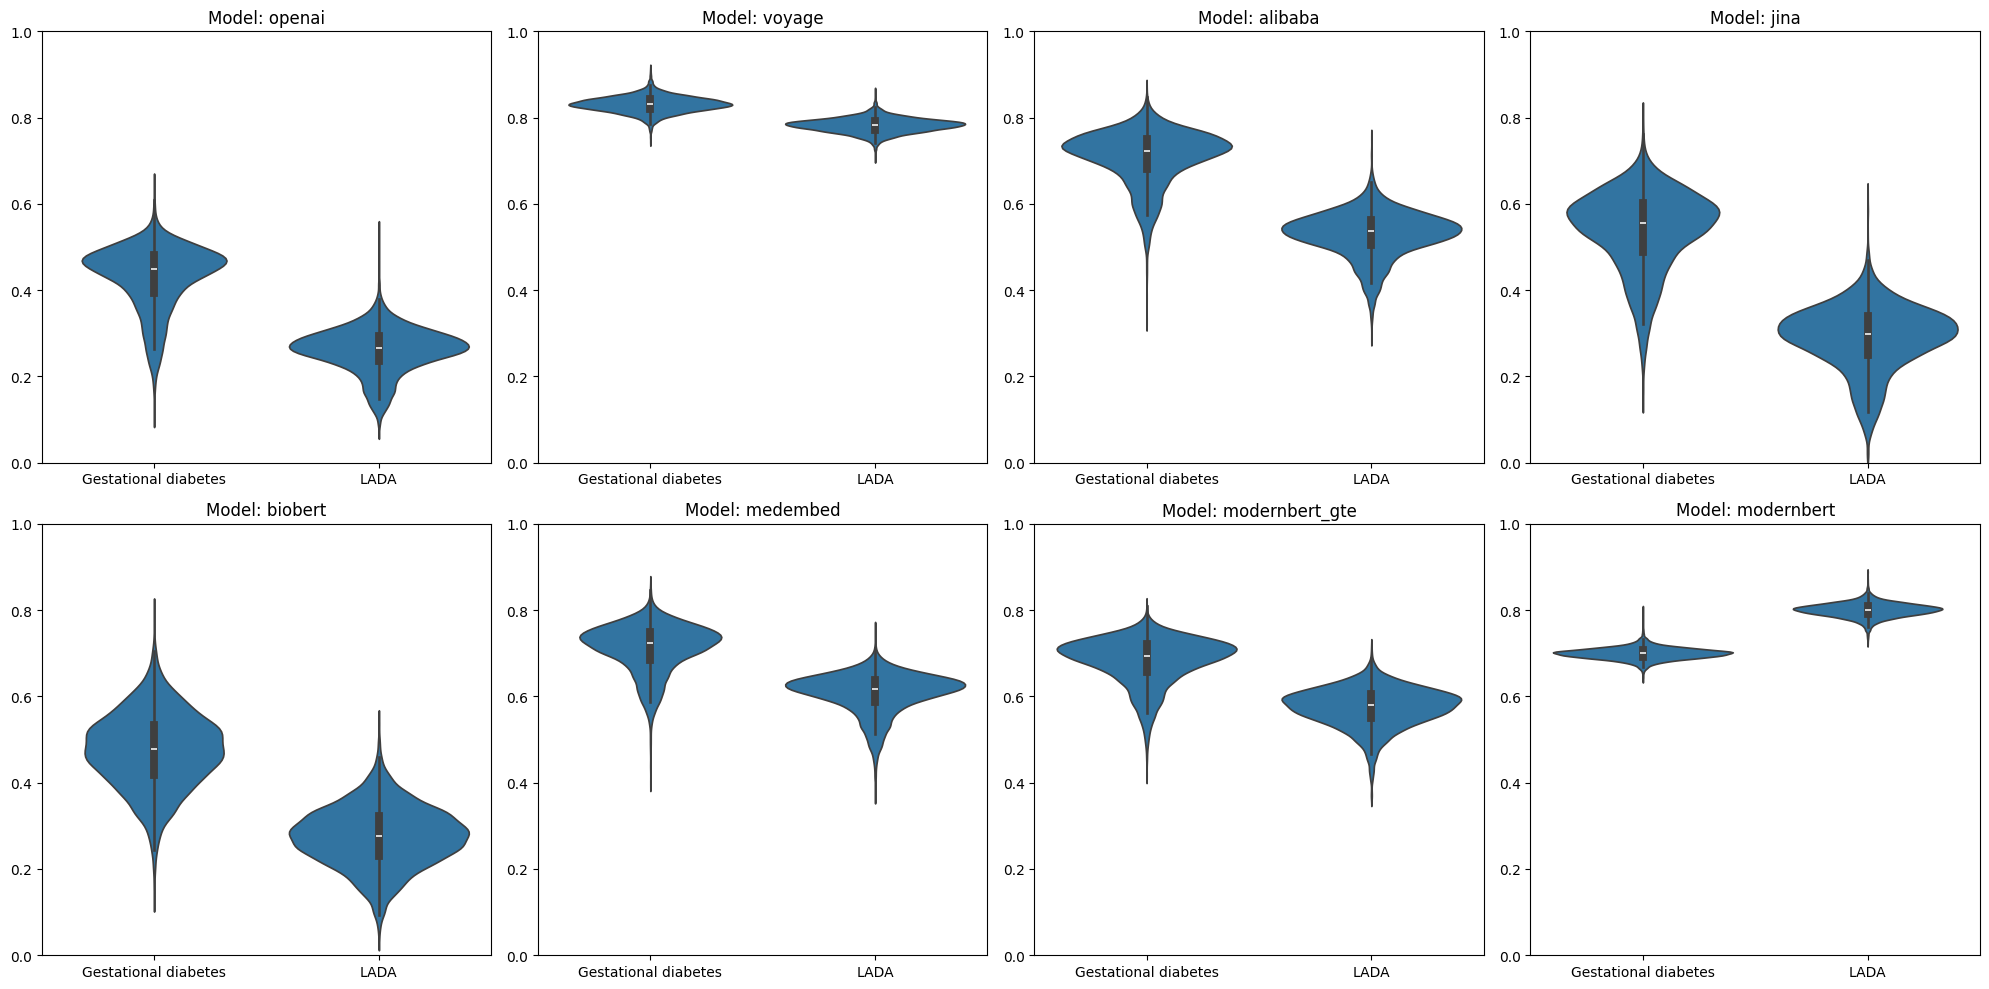

In [ ]:
plot_violin(gestational_df, ["Gestational diabetes", "Latent autoimmune diabetes in adults"])

# Tolerance to spelling errors

You can take typos from logs, create them manually or generate ([typo](https://pypi.org/project/typo/)). Anyway, make sure that typos of varoius types are represented.

In [ ]:
typos = {
    'willebrand disease': 'xillebrand disease',  # error in the beginning
    'ozempik': '0zempik',  # similar char in the beginning
    'patient': 'aptient',  # char swap in the beginning
    'pregnancy': 'regnancy',  # missing char in the beginning

    'transfusions': 'transfysions',  # error in the middle
    'diagnosis': 'diaqnosis',  # similar char in the middle
    'cystinuria': 'cystiunria',  # char swap in the middle
    'delstrigo': 'deltrigo',  # missing char in the middle

    'sclerosis': 'sclerosiq',  # error in the end
    'fatigue': 'fatiguc', # similar char in the end
    'therapy': 'therpay',  # char swap in the end
    'cyst': 'cys'  # missing char in the end
}

In [ ]:
typos_df = pd.DataFrame(list(typos.items()), columns=["word", "typo"])
typos_df.head()

,word,typo
0,willebrand disease,xillebrand disease
1,ozempik,0zempik
2,patient,aptient
3,pregnancy,regnancy
4,transfusions,transfysions


In [ ]:
for model, method, *_ in models:
    embeddings_original = get_embeddings(typos_df["word"].tolist(), model, method)
    embeddings_typos = get_embeddings(typos_df["typo"].tolist(), model, method)
    similarity_scores = np.diag(cosine_similarity(embeddings_original, embeddings_typos))

    typos_df[model] = similarity_scores

yticklabels = [f"{row.word} → {row.typo}" for row in typos_df.itertuples()]
scores_matrix = typos_df[[model for model, *_ in models]].values

Processing openai:   0%|          | 0/2 [00:00<?, ?it/s]

Processing openai:   0%|          | 0/2 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/2 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/2 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/2 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/2 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/2 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/2 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/2 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/2 [00:00<?, ?it/s]

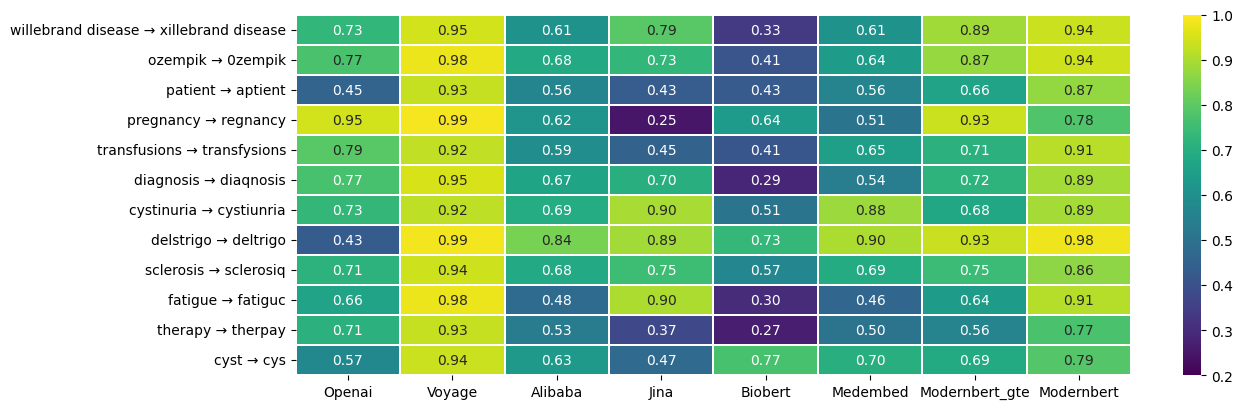

In [ ]:
fig, ax = plt.subplots(figsize=(len(models) * 1.7, len(typos_df) * 0.35))

sns.heatmap(scores_matrix, annot=True, fmt=".2f", yticklabels=yticklabels,
            xticklabels=[model.capitalize() for model, *_ in models],
            cmap='viridis', linewidths=.25, ax=ax, vmin=0.2, vmax=1)

plt.tight_layout()
plt.show()

# Domain terms

In [ ]:
import ssl
import nltk
from nltk.corpus import wordnet

ssl._create_default_https_context = ssl._create_unverified_context
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
words = list(wordnet.words())
len(words)

147306

In [ ]:
terms = [
    "lncRNA",  # Long non-coding RNAs with gene regulatory functions
    "BBB disruption therapy",  # Method of temporarily disrupting the blood-brain barrier to deliver drugs to brain tissue
    "Antisense oligonucleotide",  # Short synthetic DNA or RNA for therapy of genetic diseases and cancer
    "PD-L1 mAbs",  # Monoclonal antibodies helping the immune system recognize and destroy cancer cells
    "Kabuki syndrome",  # Rare genetic disorder
    "Waldenström Macroglobulinemia",  # A rare type of non-Hodgkin lymphoma
    "Frey syndrome",  # A condition causing facial sweating when eating
    "Ozempic",  # Drug for treating type 2 diabetes and weight management
    "Cladribine",  # Drug for treating multiple sclerosis
    "Zolgensma",  # Gene therapy for spinal muscular atrophy
    "ReoPro",  # Drug preventing blood clotting during vascular surgeries
]

In [ ]:
terms_df = pd.DataFrame(terms, columns=["term"])
terms_df.head()

,term
0,lncRNA
1,BBB disruption therapy
2,Antisense oligonucleotide
3,PD-L1 mAbs
4,Kabuki syndrome


In [ ]:
for model, method, _, batch_size in models:
    terms_embeddings = get_embeddings(terms_df["term"].tolist(), model, method)
    wordnet_embeddings = get_embeddings(words, model, method, batch_size)
    similarities = cosine_similarity(terms_embeddings, wordnet_embeddings)

    results = []
    for term, term_similarities in zip(terms, similarities):
        top_indices = np.argsort(term_similarities)[-3:][::-1]
        top_words = [words[i] for i in top_indices]
        results.append(", ".join(top_words))

    terms_df[model] = results

terms_df.head(20)

Processing openai:   0%|          | 0/2 [00:00<?, ?it/s]

Processing openai:   0%|          | 0/148 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/2 [00:00<?, ?it/s]

Processing voyage:   0%|          | 0/1474 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/2 [00:00<?, ?it/s]

Processing alibaba:   0%|          | 0/18414 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/2 [00:00<?, ?it/s]

Processing jina:   0%|          | 0/18414 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing biobert:   0%|          | 0/18414 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/2 [00:00<?, ?it/s]

Processing medembed:   0%|          | 0/18414 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert_gte:   0%|          | 0/18414 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/2 [00:00<?, ?it/s]

Processing modernbert:   0%|          | 0/18414 [00:00<?, ?it/s]

,term,openai,voyage,alibaba,jina,biobert,medembed,modernbert_gte,modernbert
0,lncRNA,"nrna, nuclear_rna, informational_rna","nuclear_rna, mrna, rna","rna, informational_rna, mrna","nrna, rna, nrl","lunda, livistona, liliales","rna, nuclear_rna, nrna","nlrb, nrna, rna","mycophage, chalcid, flecainide"
1,BBB disruption therapy,"blood-brain_barrier, thrombolytic_therapy, clo...","therapeutic, therapy, therapeutical","implosion_therapy, disrupt, therapeutical","implosion_therapy, behavior_therapy, disruption","bobsledding, bd, boding","disruption, bb, bbs","ebbtide, bas_relief, implosion_therapy","feedlot, birthwort, bombastically"
2,Antisense oligonucleotide,"nucleoside, antimetabolite, dideoxyinosine","antibody, recombinant, isoantibody","nucleoside, didanosine, mrna",non-nucleoside_reverse_transcriptase_inhibitor...,"ribonucleic_acid, antineoplastic, knock-down","nucleotide, dna, endonuclease","antipode, noncoding_dna, informational_rna","queenfish, immensurable, antihistamine"
3,PD-L1 mAbs,"cancer_drug, immunotherapeutic, anti-tnf_compound","monoclonal, monoclonal_antibody, antibody","monoclonal_antibody, immunotherapeutic, monocl...","immunoglobulin_d, monoclonal_antibody, immunoa...","mam, lgb, mamma","monoclonal_antibody, monoclonal, pd","lablab, l-p, blood_profile","l-plate, hsv-2, 401-k_plan"
4,Kabuki syndrome,"kakke_disease, noonan's_syndrome, syndrome","syndrome, korsakoff's_syndrome, abasia","kallman's_syndrome, ekbom_syndrome, syndrome","ekbom_syndrome, akinesia, korsakoff's_syndrome","kaki, kalansuwa, kawaka","korzybski, kaki, ekbom_syndrome","kuki, ekbom_syndrome, kuki-chin","giant_reed, cushaw, mortal_sin"
5,Waldenström Macroglobulinemia,"plasmacytoma, myeloma, gammopathy","agammaglobulinemia, hypogammaglobulinemia, gra...","agammaglobulinemia, multiple_myeloma, myeloma","agammaglobulinemia, myoglobinuria, megaloblast...","myoglobinuria, mulishness, hypogammaglobulinemia","agammaglobulinemia, waldenses, hypogammaglobul...","wilms_tumour, blood_profile, williams_syndrome","osteosclerosis_congenita, drepanocytic_anaemia..."
6,Frey syndrome,"hyperhidrosis, diaphoresis, polyhidrosis","syndrome, williams_syndrome, idiopathy","frey, bruxism, waterhouse-friderichsen_syndrome","syndrome, frey, reye's_syndrome","frey, freyr, freya","frey, freya, freyr","reye's_syndrome, frey, ramsay_hunt_syndrome","frostwort, foumart, fortunella"
7,Ozempic,"glucophage, glipizide, zapotecan","otic, zocor, empirin","ozena, obidoxime_chloride, oxyphencyclimine","ocimum, omotic, oecumenic","ozena, ozarks, ozaena","ozonize, typic, ozonide","zyloprim, oxytocic_drug, oxytocic","palometa, pseudemys, empyreal"
8,Cladribine,"chlorambucil, leukeran, mercaptopurine","clonidine, chlorpromazine, clomipramine","zalcitabine, lamivudine, deoxyadenosine","cladrastis, clerid, clinid","cladonia, cladrastis, cladode","clad, cladode, zalcitabine","cuprimine, calcimine, cadaverine","cladoniaceae, cladophyll, cicadellidae"
9,Zolgensma,"zoloft, lofortyx, vincristine","zetland, zinzendorf, nijmegen","zeugma, zygnema, genus_zygnema","zola, zymogen, zolaesque","ziziphus, zola, zetland","zeugma, glechoma, zygoma","zeugma, z, malosma","schmaltz, spotweld, zinfandel"
